# Solid State Angle of Attack Sensor Testing

Data analysis for the GQC prototype AoA sensor. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg

fs = 781.25e3
q = 5 #downsample

## Import and Inspect Data from Saleae

This code from [Saleae](https://support.saleae.com/faq/technical-faq/binary-export-format-logic-2).

In [2]:
import array
import struct
import sys
from collections import namedtuple

TYPE_DIGITAL = 0
TYPE_ANALOG = 1
expected_version = 0

AnalogData = namedtuple('AnalogData', ('begin_time', 'sample_rate', 'downsample', 'num_samples', 'samples'))

def parse_analog(f):
    # Parse header
    identifier = f.read(8)
    if identifier != b"<SALEAE>":
        raise Exception("Not a saleae file")

    version, datatype = struct.unpack('=ii', f.read(8))

    if version != expected_version or datatype != TYPE_ANALOG:
        raise Exception("Unexpected data type: {}".format(datatype))

    # Parse analog-specific data
    begin_time, sample_rate, downsample, num_samples = struct.unpack('=dqqq', f.read(32))

    # Parse samples
    samples = array.array("f")
    samples.fromfile(f, num_samples)

    return AnalogData(begin_time, sample_rate, downsample, num_samples, samples)

def read_length(filename):
    with open(filename, 'rb') as f:
        # Parse header
        identifier = f.read(8)
        if identifier != b"<SALEAE>":
            raise Exception("Not a saleae file")

        version, datatype = struct.unpack('=ii', f.read(8))

        if version != expected_version or datatype != TYPE_ANALOG:
            raise Exception("Unexpected data type: {}".format(datatype))

        # Parse analog-specific data
        begin_time, sample_rate, downsample, num_samples = struct.unpack('=dqqq', f.read(32))

        return num_samples

# if __name__ == '__main__':
#     filename = sys.argv[1]
#     print("Opening " + filename)

#     with open(filename, 'rb') as f:
#         data = parse_analog(f)

#     # Print out all analog data
#     print("Begin time: {}".format(data.begin_time))
#     print("Sample rate: {}".format(data.sample_rate))
#     print("Downsample: {}".format(data.downsample))
#     print("Number of samples: {}".format(data.num_samples))

#     print("  {0:>20} {1:>10}".format("Time", "Voltage"))

#     for idx, voltage in enumerate(data.samples):
#         sample_num = idx * data.downsample
#         time = data.begin_time + (float(sample_num) / data.sample_rate)
#         print("  {0:>20.10f} {1:>10.3f}".format(time, voltage))

## Implement Goertzel's Algorithm

In [3]:
#extract the tone from a short signal of interest
def goertzel(x, freq, fs = fs/q):
    n = len(x)
    k = int(0.5 + (n * freq / fs))
    w = (2 * np.pi / n) * k
    cos_w = np.cos(w)
    sin_w = np.sin(w)
    coeff = 2 * cos_w
    
    q_0 = q_1 = q_2 = 0
    for sample in x:
        q_0 = coeff * q_1 - q_2 + sample
        q_2 = q_1
        q_1 = q_0
        
    return (q_1 - q_2 * cos_w) + 1j * (q_2 * sin_w)

## Import and Goertzel the Data

In [13]:
folder = 'data/secondrun'
numchannels = 6 #number of data files
tonefreq = 41e3

step = 1000

#calculate the size of each of the final data
numpts = int(read_length(folder + "/analog_0.bin") / q / step)

tonedata = np.zeros((numchannels, numpts), dtype = np.complex128)

for i in range(numchannels):
    filename = folder + "/analog_" + str(i) + ".bin"
    print(f"Opening {filename}")
    with open(filename, 'rb') as f:
        data = sg.decimate(parse_analog(f).samples, q) #5x downsample
        
        #goertzel it
        for j in range(numpts):
            tonedata[i, j] = goertzel(data[j * step:(j + 1) * step], tonefreq)
    del data

Opening data/secondrun/analog_0.bin
Opening data/secondrun/analog_1.bin
Opening data/secondrun/analog_2.bin
Opening data/secondrun/analog_3.bin
Opening data/secondrun/analog_4.bin
Opening data/secondrun/analog_5.bin


In [5]:
# Fix the phase to prevent roll_overs
def fix_phase(x):
    phase_acc = 0
    for i in range(1, len(x)):
        x[i] += phase_acc
        phase_change = x[i] - x[i-1]
        if(phase_change > 1.9 * np.pi):
            phase_acc -= 2 * np.pi
            x[i] -= 2 * np.pi
        elif(phase_change < -1.9 * np.pi):
            phase_acc += 2 * np.pi
            x[i] += 2 * np.pi

In [6]:
angles = np.angle(tonedata)
np.shape(angles[0])
for i in range(len(angles)):
    fix_phase(angles[i])

## Visualization

In [7]:
print(np.shape(tonedata))

(6, 28852)


<IPython.core.display.Javascript object>


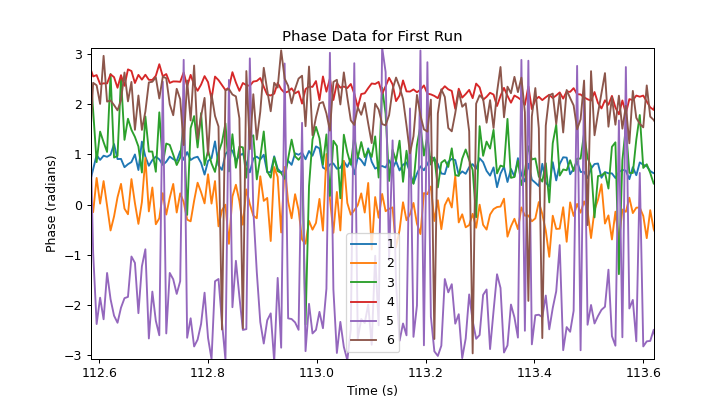

In [12]:
phaseplt = plt.figure(figsize = (9,5))
times = np.arange(0, numpts * step * q / fs, 1/fs * step * q)
for i in range(numchannels):
    plt.plot(times, np.angle(tonedata[i]))
    
plt.legend([str(i + 1) for i in range(numchannels)])
plt.title("Phase Data for First Run")
plt.xlabel("Time (s)")
plt.ylabel("Phase (radians)")
plt.show()

<IPython.core.display.Javascript object>


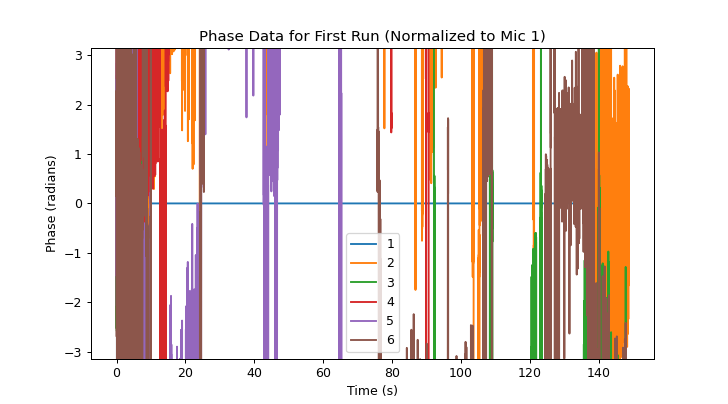

In [9]:
normalized_phaseplt = plt.figure(figsize = (9,5))
for i in range(numchannels):
    plt.plot(times[0:23240], angles[i,0:23240] - angles[0,0:23240])
    
plt.legend([str(i + 1) for i in range(numchannels)])
plt.ylim([-np.pi,np.pi])
plt.title("Phase Data for First Run (Normalized to Mic 1)")
plt.xlabel("Time (s)")
plt.ylabel("Phase (radians)")
plt.show()